# Data exploration 
Libraries and creation of Spark session has to be run only once
If you need to run again these steps, you have to restart the Kernel

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext("local[*]")
spark = SparkSession(sc)

Open CSVs and show data schema. This will guide you when writing code

In [2]:

df_b = spark.read.csv( "yelp-dataset/yelp_business.csv", header=True)
df_r = spark.read.csv( "yelp-dataset/yelp_review.csv", header=True)
df_a = spark.read.csv( "yelp-dataset/yelp_business_attributes.csv", header=True)


In [20]:
print(df_b.printSchema())
print(df_r.printSchema())
print(df_a.printSchema())

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- is_open: string (nullable = true)
 |-- categories: string (nullable = true)

None
root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)

None
root
 |-- business_id: string (nullable = true)
 |-- AcceptsInsurance: string (nullable = true)
 |-- ByAppointment

# Number of reviews by category

We need to figure out a way to identify the most sports business using categories and name fields

The example below pulls categories that are not related to our case

In [7]:
from pyspark.sql.functions import lower,col
categories=df_r.join(df_b, ["business_id", "business_id"])\
.filter(lower(df_b["categories"]).like("%sporting goods%"))#\

import pyspark.sql.functions as func
categories.groupby('categories').agg(func.count(func.lit(1)).alias('count'))\
.sort(col("count").desc()).show(truncate=False)

#.groupBy('categories').count().sort(col("count").desc()).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|categories                                                                                                                                          |count|
+----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Sporting Goods;Shopping                                                                                                                             |832  |
|Shopping;Sporting Goods                                                                                                                             |812  |
|Sporting Goods;Active Life;Guns & Ammo;Shopping;Gun/Rifle Ranges                                                                                    |466  |
|Sporting Goods;Shopping;Bikes                            

Using all categories with "sporting goods" in the description

We get 1872 companies, 24340 reviews, and 1782 company attributes

For testing we limit the reviews to 1000

In [3]:

from pyspark.sql.functions import lower,col
#spbus_df=df_b.filter(lower(df_b["categories"]).like("%sport%")|lower(df_b["name"]).like("%sport%"))
spbus_df=df_b.filter(lower(df_b["categories"]).like("%sporting goods%"))
###### REMOVE limit(1000) to run in the cluster
sprev_df = df_r.join(spbus_df.select("business_id"), ["business_id", "business_id"])#.limit(100)
spatt_df = df_a.join(spbus_df, ["business_id", "business_id"])


In [4]:
print (spbus_df.count())
print(sprev_df.count())
print (spatt_df.count())

1872
24340
1782


Checking how stars are spread on our data. It looks like we have a good spread among all 5 values

In [5]:
sprev_df.groupBy('stars').count().sort(col("count").desc()).show()

+-----+-----+
|stars|count|
+-----+-----+
|    5|13745|
|    4| 4181|
|    1| 3489|
|    3| 1567|
|    2| 1358|
+-----+-----+



Do some preliminary data cleaning and show number of records after cleaning

In [6]:
from pyspark.sql.functions import udf, regexp_replace
from pyspark.sql.types import ArrayType, StringType

#Reviews
sprev_df = sprev_df.withColumnRenamed("stars", "label")
sprev_df = sprev_df.withColumn("label", sprev_df["label"].cast("double"))
sprev_df = sprev_df.where(col("label").isNotNull())
sprev_df = sprev_df.na.fill("0",["funny", "cool","useful"])
sprev_df = sprev_df.select("text", "label")
# Clean text
sprev_df = sprev_df.withColumn("text", lower(regexp_replace(sprev_df["text"],"[^a-zA-Z\\s]","")))

#Business
spbus_df = spbus_df.dropna(subset=["latitude","longitude"])
#Attributes
spatt_df = spatt_df.na.fill("0")
#Show counts


In [7]:
print (spbus_df.count())
print(sprev_df.count())
print (spatt_df.count())


1871
24340
1782


In [9]:
import pyspark.sql.functions as func
spbus_df.groupby('city').agg(func.count(func.lit(1)).alias('count'))\
.sort(col("count").desc()).show(truncate=False)

#.groupBy('categories').count().sort(col("count").desc()).show(truncate=False)

+-----------+-----+
|city       |count|
+-----------+-----+
|Las Vegas  |214  |
|Toronto    |200  |
|Phoenix    |160  |
|Scottsdale |110  |
|Charlotte  |84   |
|Madison    |73   |
|Tempe      |71   |
|Mesa       |68   |
|Montréal   |57   |
|Henderson  |57   |
|Pittsburgh |55   |
|Edinburgh  |49   |
|Chandler   |48   |
|Glendale   |37   |
|Gilbert    |37   |
|Cleveland  |28   |
|Stuttgart  |26   |
|Peoria     |24   |
|Mississauga|22   |
|North York |17   |
+-----------+-----+
only showing top 20 rows



In [13]:
att.printSchema()

root
 |-- summary: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- AcceptsInsurance: string (nullable = true)
 |-- ByAppointmentOnly: string (nullable = true)
 |-- BusinessAcceptsCreditCards: string (nullable = true)
 |-- BusinessParking_garage: string (nullable = true)
 |-- BusinessParking_street: string (nullable = true)
 |-- BusinessParking_validated: string (nullable = true)
 |-- BusinessParking_lot: string (nullable = true)
 |-- BusinessParking_valet: string (nullable = true)
 |-- HairSpecializesIn_coloring: string (nullable = true)
 |-- HairSpecializesIn_africanamerican: string (nullable = true)
 |-- HairSpecializesIn_curly: string (nullable = true)
 |-- HairSpecializesIn_perms: string (nullable = true)
 |-- HairSpecializesIn_kids: string (nullable = true)
 |-- HairSpecializesIn_extensions: string (nullable = true)
 |-- HairSpecializesIn_asian: string (nullable = true)
 |-- HairSpecializesIn_straightperms: string

In [14]:
#clean data to start preprocessing
sprev_df.select("label","text").show()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|  5.0|i just love love ...|
|  1.0|i have been calli...|
|  3.0|it was picking up...|
|  4.0|how can you not l...|
|  3.0|not a bad store i...|
|  3.0|while it may be b...|
|  2.0|the only time i w...|
|  5.0|i am not sure how...|
|  5.0|im not a runner i...|
|  2.0|i saw that the ru...|
|  2.0|ah yes finish lin...|
|  3.0|so i will say tha...|
|  4.0|what can you say ...|
|  5.0|well i have been ...|
|  5.0|the better of the...|
|  3.0|i am familiar wit...|
|  3.0|on the smaller si...|
|  4.0|rei is heaven for...|
|  4.0|bikesource is a g...|
|  2.0|local outdoor sto...|
+-----+--------------------+
only showing top 20 rows



Install NLTK

pip install --user -U nltk


# Clean and Pre-Process reviews
1. Remove punctuation and convert to lowercase (done above)
2. Tokenize the text
3. Remove stop words
4. Stem text
5. Remove short words

In [5]:

from pyspark.ml.feature import  StopWordsRemover, CountVectorizer,Tokenizer
from nltk.stem.snowball import SnowballStemmer


#Tokenize the text in the text column
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsDataFrame = tokenizer.transform(sprev_df)


#remove 20 most occuring documents, documents with non numeric characters, and documents with <= 3 characters
cv_tmp = CountVectorizer(inputCol="words", outputCol="tmp_vectors")
cv_tmp_model = cv_tmp.fit(wordsDataFrame)


top20 = list(cv_tmp_model.vocabulary[0:20])
more_then_3_charachters = [word for word in cv_tmp_model.vocabulary if len(word) <= 3]
contains_digits = [word for word in cv_tmp_model.vocabulary if any(char.isdigit() for char in word)]
englishwords = StopWordsRemover.loadDefaultStopWords("english")
stopwords = ["a","able","about","above","abst","accordance","according","accordingly","across","act","actually",
             "added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all",
             "almost","alone","along","already","also","although","always","am","among","amongst","an","and",
             "announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways",
             "anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask",
             "asking","at","auth","available","away","awfully","b","back","be","became","because","become",
             "becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins",
             "behind","being","believe","below","beside","besides","between","beyond","biol","both","brief",
             "briefly","but","by","c","ca","came","can","cannot","cant","cause","causes","certain","certainly",
             "co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did",
             "didnt","different","do","does","doesnt","doing","done","dont","down","downwards","due","during",
             "e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending",
             "enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything",
             "everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following",
             "follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave",
             "get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had",
             "happens","hardly","has","hasnt","have","havent","having","he","hed","hence","her","here",
             "hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself",
             "his","hither","home","how","howbeit","however","hundred","i","id","ie","if","ill","im","immediate",
             "immediately","importance","important","in","inc","indeed","index","information","instead","into",
             "invention","inward","is","isnt","it","itd","itll","its","itself","ive","j","just","k","keep",
             "keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter",
             "latterly","least","less","lest","let","lets","like","liked","likely","line","little","ll","look",
             "looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means",
             "meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly",
             "mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly",
             "necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine",
             "ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted",
             "nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay",
             "old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise",
             "ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages",
             "part","particular","particularly","past","per","perhaps","placed","please","plus","poorly",
             "possible","possibly","potentially","pp","predominantly","present","previously","primarily",
             "probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather",
             "rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards",
             "related","relatively","research","respectively","resulted","resulting","results","right","run","s",
             "said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming",
             "seems","seen","self","selves","sent","seven","several","shall","she","shed","shell","shes","should",
             "shouldnt","show","showed","shown","showns","shows","significant","significantly","similar","similarly",
             "since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime",
             "sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying",
             "still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup",
             "sure","ts","take","taken","tell","tends","th","than","thank","thanks","thanx","that","thats",
             "the","their","theirs","them","themselves","then","thence","there","theres","thereafter","thereby",
             "therefore","therein","theres","thereupon","these","they","theyd","theyll","theyre","theyve","think",
             "third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus",
             "to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two",
             "un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful",
             "uses","using","usually","value","various","very","via","viz","vs","want","wants","was","wasnt","way",
             "we","wed","well","were","weve","welcome","well","went","were","werent","what","whats","whatever",
             "when","whence","whenever","where","wheres","whereafter","whereas","whereby","wherein","whereupon",
             "wherever","whether","which","while","whither","who","whos","whoever","whole","whom","whose","why","will",
             "willing","wish","with","within","without","wont","wonder","would","wouldnt","yes","yet","you","youd",
             "youll","youre","youve","your","yours","yourself","yourselves","zero","template","align","center","cite",
             "style","left","web","flagicon","references","rowspan","width","infobox","colspan","class","time",
             "external","links","background","reflist","area","bgcolor","wikitable","top","http","reflisttemplate",
             "including","list","main","icon","coord","title","webtemplate","border","website","row","include",
             "site","col","set","large","san","valign","color","sort","halign","align","dfdddf","dfbbbf",
             "persondatadefaultsort","rt","really","tried","told","tell","living","getting","pros","cons","come","else",
             "reason","fun","sure","excess","side","way","away","past","cannot","also","even","get","although","nothing",
             "part","confirmed","huge","heard","enjoyed","enjoy","great","excellent","nice","amazing","loved","love",
             "beautiful","awesome", "wonderful","great","bit","thank","fantastic","perfect","little","helpful","happy",
             "highly","incredible","good","terrible","worst","horrible","poor","broken","manager","ever", "worst",
             "awful","hair","dime","family","everyone","easy","quick","treat","terribly","lot","rude","called",
             "car","complained","someone","phone","wynn","except","able","run","nickel","someone","easy","happy",
             "newly","comfimed","theyr","excuse","best","complain","beyond","apology","guest","said","glad",
             "multiple","disgust","friendly","call","bad","wall","charged","sheet","nasty","body","thin","ruined",
             "joke","worse","outstanding","pleasant","promised","elsewhere","terribly","professional",
             "unprofessional","manager","dont","waited","customer","booked","move","disappointed","pm","asked",
             "wrong","money","left","care","bug","changed","change","completely","contacted","work","sit","hour",
             "upgraded","pay","paid","well","old","large","used","sorry","understand","type","smaller","kind","quite",
             "bringing","guess","real","finally","okay","personality","probably","insanely","typically","kinda","yesterday",
             "usually","greatly","need","absolutely","willing","husband","years","itll","yetwel"]

#Combine the four stopwords
stopwords = stopwords + top20 + more_then_3_charachters + contains_digits + englishwords

#Remove stopwords from the tokenized list
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords = stopwords)
wordsDataFrame = remover.transform(wordsDataFrame)

# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
wordsDataFrame = wordsDataFrame.withColumn("words_stemmed", stemmer_udf("filtered")).select('*', 'words_stemmed')


#Create a new CountVectorizer model without the stopwords
cv = CountVectorizer(inputCol="words_stemmed", outputCol="features")
cvmodel = cv.fit(wordsDataFrame)
df_final_reviews = cvmodel.transform(wordsDataFrame)


In [17]:
#Data ready to analyze
df_final_reviews.select("label","text","words_stemmed").show()

+-----+--------------------+--------------------+
|label|                text|       words_stemmed|
+-----+--------------------+--------------------+
|  5.0|i just love love ...|[place, staff, pl...|
|  1.0|i have been calli...|[call, email, sto...|
|  3.0|it was picking up...|[pick, number, sw...|
|  4.0|how can you not l...|[bore, gear, hike...|
|  3.0|not a bad store i...|[store, small, cr...|
|  3.0|while it may be b...|[bigger, lot, thi...|
|  2.0|the only time i w...|[return, simpl, a...|
|  5.0|i am not sure how...|[place, rate, exp...|
|  5.0|im not a runner i...|[runner, shape, s...|
|  2.0|i saw that the ru...|[run, room, start...|
|  2.0|ah yes finish lin...|[finish, west, to...|
|  3.0|so i will say tha...|[banana, republ, ...|
|  4.0|what can you say ...|[sport, apparel, ...|
|  5.0|well i have been ...|[come, mountain, ...|
|  5.0|the better of the...|[better, adida, l...|
|  3.0|i am familiar wit...|[familiar, locat,...|
|  3.0|on the smaller si...|[compar, rei, sel...|


Prepare the training anf test data:

Low satisfaction = stars<=3  label =0

High saisfaction = stars>=4  label =1

Create the Train and Test DataFrames combining low and high satisfaction


In [6]:
from pyspark.sql.functions import lit
highsat =df_final_reviews.filter(df_final_reviews["label"]>=4).withColumn("label",lit(1)) 
lowsat = df_final_reviews.filter(df_final_reviews["label"]<=3).withColumn("label",lit(0)) 
highsat_train, highsat_test = highsat.randomSplit([0.7, 0.3], seed=12345)
lowsat_train, lowsat_test = lowsat.randomSplit([0.7, 0.3], seed=12345)
train_data = highsat_train.union(lowsat_train).select("label","features","words_stemmed")
test_data = highsat_test.union(lowsat_test).select("label","features","words_stemmed")

# Logitic Regression
Create the pipeline and the model for logistic regression with cross-validation K-fold =10

Train the model and evaluate the results

In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=20)#, regParam=0.3, elasticNetParam=0)
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0001, 0.0003, 0.0005]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.01, 0.02]) # Elastic Net Parameter (Ridge = 0)
             .build())
# Create 10-fold CrossValidator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=10)
cvModel = cv.fit(train_data)
#model = lr.fit(train_data)
predictions = cvModel.transform(test_data)
# Evaluate best model
e=evaluator.evaluate(predictions)
print(e)

0.5732560122804025


In [8]:
#Test some Prediction
selected = predictions.select("label","prediction")
sample =  selected.limit(10)
id=0
for row in sample.collect():
    label, prediction = row
    id=id+1
    print("Comment %d, Actual:%f --> prediction = %f" %(id,label, prediction))

Comment 1, Actual:1.000000 --> prediction = 1.000000
Comment 2, Actual:1.000000 --> prediction = 1.000000
Comment 3, Actual:1.000000 --> prediction = 1.000000
Comment 4, Actual:1.000000 --> prediction = 1.000000
Comment 5, Actual:1.000000 --> prediction = 1.000000
Comment 6, Actual:1.000000 --> prediction = 1.000000
Comment 7, Actual:1.000000 --> prediction = 1.000000
Comment 8, Actual:1.000000 --> prediction = 1.000000
Comment 9, Actual:1.000000 --> prediction = 1.000000
Comment 10, Actual:1.000000 --> prediction = 1.000000


In [12]:
#Grab the positive and negative sentiment reviews
pos_rev = predictions.filter(predictions["prediction"]==1).select("features","words_stemmed")
neg_rev = predictions.filter(predictions["prediction"]==0).select("features","words_stemmed")

# LDA Classification
Classify the possitive and negative comments to discover the most talked about topics

In [13]:
from pyspark.ml.clustering import LDA

lda = LDA(k=10, maxIter=10)
model_pos = lda.fit(pos_rev)
model_neg = lda.fit(neg_rev)


In [15]:
topics = model_pos.describeTopics(10)
print (" ################# POSITIVE TOPICS ################")
for topic in topics.rdd.toLocalIterator():
    print("Topic: " + str(topic[0]))
    words = ""
    for n in range(len(topic[1])):
        words = words + cvmodel.vocabulary[topic[1][n]]+ ","
    print (words)

 ################# POSITIVE TOPICS ################
Topic: 0
logo,page,numer,total,imagin,onlin,fender,msrp,workoutahol,close,
Topic: 1
better,locat,adida,town,busi,vlos,hectic,work,villag,twist,
Topic: 2
heart,shape,madison,top,down,lookin,complet,develop,fit,earth,
Topic: 3
friday,multisport,unpretenti,sock,eric,salesperson,juif,abroad,birthday,pull,
Topic: 4
amazon,price,thing,medicin,cheapercommon,sidewalk,ball,food,sens,find,
Topic: 5
difficult,friendlier,cours,sens,import,brightest,place,mall,closer,serv,
Topic: 6
store,select,gear,employe,busi,local,cloth,star,clean,perus,
Topic: 7
lazi,trip,grip,assist,hard,alex,person,ware,rei,banquet,
Topic: 8
packer,adorn,owner,corner,suppos,help,group,multisport,handgun,run,
Topic: 9
bike,place,time,shop,minut,guy,help,wheel,break,true,


In [44]:
topics = model_neg.describeTopics(10)
print ("############ NEGATIVE TOPICS ###########")
for topic in topics.rdd.toLocalIterator():
    print("Topic: " + str(topic[0]))
    words = ""
    for n in range(len(topic[1])):
        words = words + cvmodel.vocabulary[topic[1][n]]+ ","
    print (words)

Negative topics
Topic: 0
ocean,wholefood,rei,white,handgun,wore,shannon,woman,indepth,refresh,
Topic: 1
store,servic,experi,shoe,help,sale,size,time,josh,star,
Topic: 2
exchangeim,innov,interact,bicycl,houpert,treadmil,crave,beverag,peai,fork,
Topic: 3
betti,bar,level,flipflop,jose,rediect,silk,raffl,georg,himyou,
Topic: 4
clark,overpron,hous,perform,automat,know,corpor,hyatt,sweati,join,
Topic: 5
shame,capri,insol,cold,alma,machin,villeneuv,novel,cadenc,choos,
Topic: 6
chees,inhous,skateboard,frozen,inquiri,stand,stack,cloth,unbeat,cramp,
Topic: 7
nicest,compet,firearm,space,generous,waiv,tube,gel,chuckl,perfect,
Topic: 8
instal,fender,bike,tire,bolt,sold,rub,wheel,hand,small,
Topic: 9
cardin,thank,earn,luke,fine,bestlook,velofix,chop,rhetor,someon,


In [16]:
######Negative talked about words
print ("############ NEGATIVE WORDS ###########")
neg_freq=neg_rev.select("words_stemmed")
neg_words=neg_freq.rdd.flatMap(lambda a: [(w,1) for w in a.words_stemmed]).reduceByKey(lambda a,b: a+b).sortBy(lambda a:-a[1]).take(20)
print (neg_words)

############ NEGATIVE WORDS ###########
[('small', 7), ('scottsdal', 2), ('choos', 2), ('coupon', 2), ('super', 1), ('impress', 1), ('walk', 1), ('figur', 1), ('feel', 1), ('current', 1), ('women', 1), ('full', 1), ('suspens', 1), ('receiv', 1), ('type', 1), ('drove', 1), ('take', 1), ('minut', 1), ('shop', 1), ('servic', 1)]


Install necesary libraries for geoploting

conda install geopandas

conda install descartes

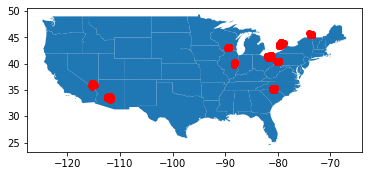

In [39]:
#Do something with Long Lat
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

#Only plot business in the US
us_bus = spbus_df.filter(spbus_df["longitude"]>=-126.56).filter(spbus_df["longitude"]<=-66.45)\
.filter(spbus_df["latitude"]>=25.17).filter(spbus_df["latitude"]<=48.92)

geobus_df = us_bus.select("*").toPandas()
geobus_df["longitude"] = pd.to_numeric(geobus_df["longitude"], downcast="float")
geobus_df["latitude"] = pd.to_numeric(geobus_df["latitude"], downcast="float")

gdf = geopandas.GeoDataFrame(
    geobus_df, geometry=geopandas.points_from_xy(geobus_df.longitude, geobus_df.latitude))


# Read in the shapefile from cb_2016_us_state_500k as "states"
states = gpd.read_file("cb_2016_us_state_500k/cb_2016_us_state_500k.shp")
# Get rid of Guam, Mariana Islands and Virgin Islands
states = states[states.STATEFP.astype(int) < 60]
# Get rid of Hawaii and Alaska
states = states[~states.NAME.isin(['Hawaii', 'Alaska'])]
states.tail(5)

ax = states.plot()
gdf.plot(ax=ax, color='red')
plt.show()


